Goal: 
    1. Binary Classification [One vs. Rest]
    2. Performance Metrics; acc (cannot solely rely on this), precision, TPR, ROC Curve
    3. Multilabel vs. Multiclass Classification 

In [196]:
import os
from six.moves import urllib
import tarfile
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import Imputer, LabelEncoder,OneHotEncoder,LabelBinarizer, StandardScaler, minmax_scale
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline,FeatureUnion,make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.metrics import precision_score,recall_score,f1_score,precision_recall_curve,roc_curve,roc_auc_score
from sklearn.model_selection import cross_val_score,cross_val_predict, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import SCORERS
from sklearn.multiclass import OneVsOneClassifier
import warnings
from sklearn.compose import ColumnTransformer
warnings.filterwarnings("ignore")

Fetch and load the MNIST Data

In [10]:
# Available on: https://www.openml.org/d/554
# This dataset is already saved as a tuple(data,target,object) and each one of the elements are accessible
mnist = fetch_openml('mnist_784',version=1,return_X_y=True) #tuple containing data, and target 

(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array(['5', '0', '4', ..., '4', '5', '6'], dtype=object))


Explore the data

In [130]:
data = mnist[0]
target = mnist[1].astype(np.int)
print (target)
# print(data.shape)
# print(type(target[0]))

[5 0 4 ... 4 5 6]


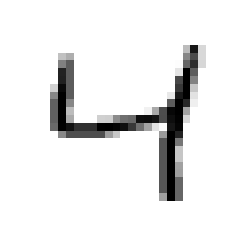

In [131]:
data[0].shape # (487,)
# Each row of the matrix representing 784 pixels associated with each digit image
plt.imshow(X[2].reshape(28,28),cmap = mpl.cm.binary)
plt.axis('off')
plt.show()

Set the test set aside and train and evaluate the model on the training set

In [144]:
# Out of 70000 samples in MNIST, the first 60000 are train, and the rest 10000 are for testing
np.sum(np.isnan(data))
rand_ind = np.random.permutation(X.shape[0])
X = data[rand_ind]
y = target[rand_ind]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 10000)
ss = StandardScaler()
X_train_transformed = ss.fit_transform(X_train)
x_test_transformed = ss.transform(X_test)
# X_test,y_test = X[60000:],y[60000:]
# print (np.shape(X_train[:]))

Binary Classification -- Training Score

In [160]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
# print ((np.where(y_train == 5))) #Find indices
sgd = SGDClassifier(random_state = 42)
sgd.fit(X_train_transformed,y_train_5)
y_pred = sgd.predict(X_train_transformed) # Label
sc = sgd.score(X_train_transformed,y_train_5)
precision = precision_score(y_train_5,y_pred)
recall = recall_score(y_train_5,y_pred) # TPR
# # f1_score = f1_score(y_train_5,y_pred)
# # print (f1_score)
print ('5_or_not Binary Classification Training Scores:\nAccuracy = %.2f'%(sc),'\nPrecision = %.2f'%(precision),'\nRecall = %.2f'%(recall))


(array([    0,     3,     7, ..., 59936, 59946, 59961], dtype=int64),)
5_or_not Binary Classification Training Scores:
Accuracy = 0.97 
Precision = 0.89 
Recall = 0.76


Binary Classification -- Validation Score/Accuracy

In [155]:
# SGD might be overfitting the training data
val_sc = cross_val_score(sgd,X_train_transformed,y_train_5)
print ('Validation Accuracy = %.2f (+/-) %.2f'%(np.mean(val_sc),np.std(val_sc)))
# SCORERS.keys()

Validation Accuracy = 0.97 (+/-) 0.00


Precision-Recall Trade-off by Changing the Threshold

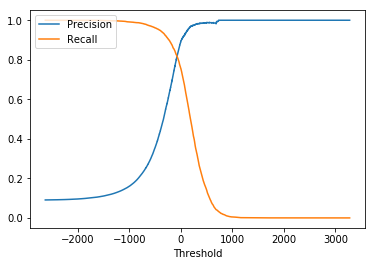

In [169]:
# SGD: 
# '+' Class: assigned_score > threshold (by decision_function)
# '-' Class: assigned_score < threshold 
# What are the scores associated with each prediction
y_sc = sgd.decision_function(X_train_transformed)
# print (y_sc[0:4]) # indices 0 and 3 (with the value of 5) have the highest scores
# val_sc2 = cross_val_score(sgd, X_train[:],y_train_5)
# **** Notice the precision curve not being smooth compared with recall ***
precision,recall,thresholds = precision_recall_curve(y_train_5,y_sc)
plt.plot(thresholds,precision[:-1],label = 'Precision')
plt.plot(thresholds,recall[:-1],label = 'Recall')
plt.legend(loc='upper left')
plt.xlabel('Threshold')
plt.show()

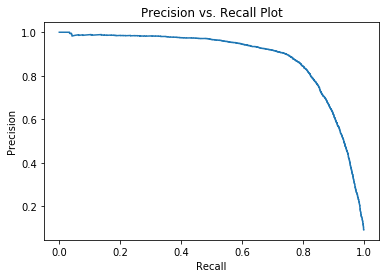

In [172]:
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall Plot')
plt.show()

The higher the threshold:
    1. Precision: higher 
    2. Recall: lower 

RandomForestClassifier Performance -- Binary Classification

In [186]:
rf = RandomForestClassifier(n_estimators=10,random_state=42).fit(X_train_transformed,y_train_5)
y_pred_rf = rf.score(X_train_transformed,y_train_5)
precision_rf = precision_score(y_train_5,y_pred)
recall_rf = recall_score(y_train_5,y_pred) # TPR
# # f1_score = f1_score(y_train_5,y_pred)
# # print (f1_score)
print ('5_or_not Binary Classification Training Scores(by RF):\nAccuracy = %.2f'%(sc),'\nPrecision = %.2f'%(precision_rf),'\nRecall = %.2f'%(recall_rf))
# *** Predict the probability of the target associating with a class ***
y_prob = cross_val_predict(rf,X_train_transformed,y_train_5,method='predict_proba')
print (y_prob)
y_sc_rf = y_prob[:,1] # Why are we selecting the 2nd col?
fpr_rf,tpr_rf,thresh_rf = roc_curve(y_train_5,y_sc_rf)

5_or_not Binary Classification Training Scores(by RF):
Accuracy = 0.97 
Precision = 0.89 
Recall = 0.76
[[0.  1. ]
 [1.  0. ]
 [1.  0. ]
 ...
 [1.  0. ]
 [1.  0. ]
 [0.8 0.2]]


Binary Classification ROC Curve and AUC 

SGD AUC = 0.98
RF AUC = 0.98


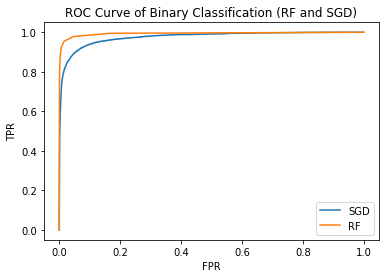

In [193]:
fpr,tpr,thresh = roc_curve(y_train_5,y_sc)
auc_sc = roc_auc_score(y_train_5,y_sc)
auc_sc_rf = roc_auc_score(y_train_5,y_sc)
print('SGD AUC = %.2f'%(auc_sc))
print('RF AUC = %.2f'%(auc_sc_rf))
plt.plot(fpr,tpr,label = "SGD")
plt.plot(fpr_rf,tpr_rf,label = "RF")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve of Binary Classification (RF and SGD)')
plt.legend(loc = 'bottom right')
plt.show()

Find the relatively best performing model by comparing differnt models evaluation metrics

In [75]:
sgd = SGDClassifier() # Managing multiclass classification well
sgd.fit(X_train[6:10],y_train[6:10])
y_pred = sgd.predict(X_train[6:10])
print (y_pred)
print (y_train[6:10])
sc = sgd.score(X_train[6:10],y_train[6:10])
prec = precision_score(y_train[6:10],y_pred,average='micro')

print (sc)
print (prec)
# RFC

[7 7 5 5]
[7 7 5 5]
1.0
1.0


6. Multiclass Classification - Image Recognition

Summary:
_____________________

1. Binary vs. Multiclass, multilabel and multioutput Classification
2. Various performance Metrics: Accuracy, Precision, Recall, F1 Score, ROC Curve(AUC Score)
    Our choice of perf metric depends on the scope of the problem at hand
    We can choose to have a higher precision or recall by setting a threshold value
    ROC gives us the ability to compare models visually
3. Multiclass Classification
    Algs handling multiclass classification
    one-vs-one - ex: SVM
    one-vs-all
    